# Model Evaluation & Testing

In this notebook, we assess the performance of the trained **GoogLeNet** model on the test dataset.  
This step is essential to understand how well the model generalizes to new, unseen data.

The test images are processed consistently with the training pipeline to ensure reliable evaluation.  
The trained model is loaded and applied to the test dataset to generate predictions.

We summarize the model’s performance using a **classification report** and a **confusion matrix**, which together provide a comprehensive view of its accuracy and capability to differentiate between the different blood cancer cell classes.

This evaluation step completes the model development pipeline, offering insights into its strengths and areas for potential improvement before deployment or further refinement.


c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


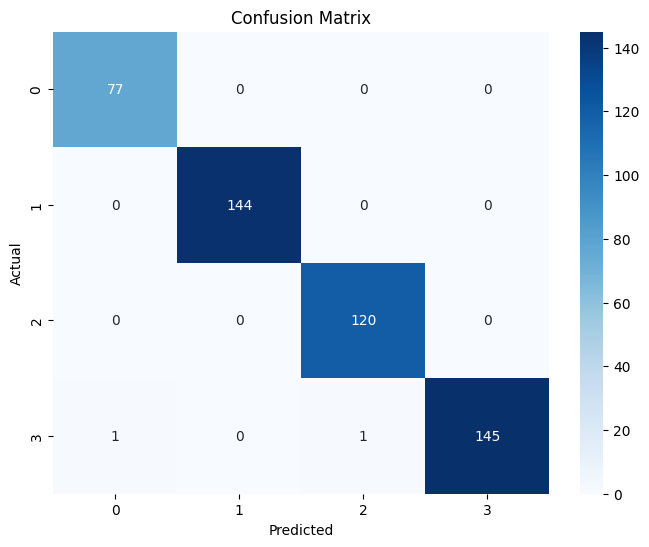

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        77
           1       1.00      1.00      1.00       144
           2       0.99      1.00      1.00       120
           3       1.00      0.99      0.99       147

    accuracy                           1.00       488
   macro avg       0.99      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488



In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Data 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


test_dir = "../data/splits/test"

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#  Hyperparameters 
num_classes = 4  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "../models/best_googlenet_model.pth"


# Define the model

googlenet = models.googlenet(pretrained=False, aux_logits=False)  
googlenet.fc = nn.Sequential(
    nn.Linear(googlenet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
googlenet.to(device)

#  Load the trained weights 
googlenet.load_state_dict(torch.load(model_path, map_location=device))
googlenet.eval()

#   Evaluate on the test set 
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#  Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#  Classification Report
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)])
print("Classification Report:\n", report)
